# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-S109A Introduction to Data Science 

## Final Exam: Airline Delays

**Harvard University**<br/>
**Summer 2020**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt


#from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.metrics import r2_score 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


#from sklearn.linear_model import LogisticRegressionCV 
#from sklearn.linear_model import LogisticRegression 
#from sklearn.utils import resample
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [3]:
### cs109default ### 
# TensorFlow and tf.keras
import tensorflow as tf

print(tf.__version__)  # You should see a 2.2.0 here!

2.2.0


In [4]:
# pip install --upgrade tensorflow

<hr style="height:2pt">

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

# Load data
nov19 = pd.read_csv('data/flightdelays_nov19.csv')
dec19 = pd.read_csv('data/flightdelays_dec19.csv')
jan20 = pd.read_csv('data/flightdelays_jan20.csv')
feb20 = pd.read_csv('data/flightdelays_feb20.csv')


print(nov19.shape,dec19.shape,jan20.shape,feb20.shape)

(602453, 28) (625763, 28) (607346, 28) (574268, 28)


In [6]:
#data_dir = '/content/drive/My Drive/S109A Data/Final/final/data'

# Predicting Flight Delays

The Bureau of Trapnsportaions Statistics houses many datasets, including detailed information about every domestic flight's departure and arrival information, see [here](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236).

The variables included are:

- `year`: the year of the flight (2019 or 2020)
- `month`: the month of the flight where 1 = January, for example
- `day_of_month`: the day of the month
- `day_of_week`: the day of the week where 1 = Monday, 2 = Tuesday, etc.
- `carrier`: the unique airline carrier code.  See [here](https://www.transtats.bts.gov/Fields.asp?Table_ID=273)
- `tail_number`: the unique tail number of the aircraft.
- `origin`: 3-letter code for the originating airport of the flight
- `origin_state`: the FIPS code of the state the origin airport is located.  See [here](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696). 
- `dest`: 3-letter code for the destination airport of the flight
- `dest_state`: the FIPS code of the state the destination airport is located.
- `scheduled_depart_time`: scheduled departure time, in HHMM format (1730 is 5:30pm.)
- `actual_depart_time`: the actual departure time, in HHMM format
- `depart_delay`: the difference between actual and scheduled departure times, in minutes (negative means it departed early)
- `taxi_out`: the time it took for the flight to take off after leaving the gate, in minutes
- `taxi_in`: the time it took for the flight to arrive at the gate after landing
- `scheduled_arrival_time`: the scheduled arrival time, in HHMM format
- `actual_arrival_time`: the actual arrival time, in HHMM format
- `arrival_delay`: the difference between actual and scheduled arrival times, in minutes (negative means it arrived early)
- `cancelled`: an indicator for whether the flight was cancelled.
- `diverted`: an indicator for whether the flight was diverted to a different airport.
- `elapsed_time`: total time from gate-to-gate
- `air_time`: time in the air between take-off and landing
- `distance`: the distance of the flight, in miles
- `carrier_delay`: the amount of time the flight was delayed due to carrier-controllable problems
- `weather_delay`: the amount of time the flight was delayed due to sever weather
- `nas_delay`: the amount of time the flight was delayed due to issues in the national aviation system
- `security_delay`: the amount of time the flight was delayed due to security issues 
- `late_aircraft_delay`: the amount of time the flight was delayed due to the aircraft arriving late from another flight.

*Note: see [here](https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations) for more details on the delay types.

Use the provided data sets (`flightdelays_nov19.csv`,`flightdelays_dec19.csv`,`flightdelays_jan20.csv`, and `flightdelays_feb20.csv`) to answer the following questions:

# <div class='exercise'><b>Question 1 [30pts]: Data Wrangling and Explorations </b></div>

**1.1** Combine the four flight data sets (each one represents a different month from November 2019 until Feb 2020).

**1.2** Next, let's perform some data wrangling: 
1. drop the flights that were cancelled or diverted
2. convert the 5 `_delay` variables at the end of the dataset into indicators whether or not there was any delay due to this reason (you will need to impute zeros for missing values, and convert any non-zeros into ones).  
3. convert `scheduled_depart_time` and `scheduled_arrival_time` into minutes (Hint: the operations `\\` and `%` will be useful for this).
How many flights were dropped?  How many observations were imputed in each of the `_delay` variables (they should all be the same)?  Save your cleaned data frame as `flights`. 

**1.3** Create a new variable called `delayed` that measures whether or not a flight was delayed by 15 minutes or more at arrival. This will be one of your primary response variables.

**1.4** Split the data, 50-50, into `train` and `test` using `random_state = 109` and `shuffle = True` in sklearn's `train_test_split`.  Why is it important to shuffle the data set first?

**1.5** Create two datasets called `bos_flights_train` and `bos_flights_test` which contains only the flights either departing from or arriving at Boston's Logan Airport in the train and test sets from the previous part.  

**1.6** Answer some exploratory questions: 
1. What proportion of flights were delayed in total?  Which month had the highest proportion of flights delayed?
2. Which airport was the busiest (had the most flights in and out)?  
3. Which airport had the highest proportion of departures delayed? 
4. Which airlines had the highest and least proportion of arrivals delayed?
5. How many flights did Boston have over this time period (combined across train and test counts)?  
6. What proportion of departing flights from Boston's Logan Airport were delayed in train?  
7. How do the distributions of arrival delays compare in flight leaving Boston vs. flights arriving at Boston (in train).  Provide a visual and interpret what you see.


In [7]:
# Load data
#nov19 = pd.read_csv(f'{data_dir}/flightdelays_nov19.csv')
#dec19 = pd.read_csv(f'{data_dir}/flightdelays_dec19.csv')
#jan20 = pd.read_csv(f'{data_dir}/flightdelays_jan20.csv')
#feb20 = pd.read_csv(f'{data_dir}/flightdelays_feb20.csv')

# Load data
nov19 = pd.read_csv('data/flightdelays_nov19.csv')
dec19 = pd.read_csv('data/flightdelays_dec19.csv')
jan20 = pd.read_csv('data/flightdelays_jan20.csv')
feb20 = pd.read_csv('data/flightdelays_feb20.csv')


print(nov19.shape,dec19.shape,jan20.shape,feb20.shape)



(602453, 28) (625763, 28) (607346, 28) (574268, 28)



**1.1** Combine the four flight data sets (each one represents a different month from November 2019 until Feb 2020).

In [8]:
# 1.1 
flights = pd.concat([nov19,dec19,jan20,feb20])
print(flights.shape)
flights.head()

(2409830, 28)


,year,month,day_of_month,day_of_week,carrier,tail_number,origin,origin_state,dest,dest_state,scheduled_depart_time,actual_depart_time,depart_delay,taxi_out,taxi_in,scheduled_arrival_time,actual_arrival_time,arrival_delay,cancelled,diverted,elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2019,11,23,6,WN,N220WN,RSW,12,CMH,39,1505,1457.0,-8.0,10.0,2.0,1725,1710.0,-15.0,0,0,133.0,121.0,930,NaN,NaN,NaN,NaN,NaN
1,2019,11,23,6,WN,N490WN,RSW,12,CMH,39,2130,2121.0,-9.0,10.0,3.0,2350,2335.0,-15.0,0,0,134.0,121.0,930,NaN,NaN,NaN,NaN,NaN
2,2019,11,23,6,WN,N489WN,RSW,12,DAL,48,1915,1908.0,-7.0,10.0,15.0,2115,2104.0,-11.0,0,0,176.0,151.0,1005,NaN,NaN,NaN,NaN,NaN
3,2019,11,23,6,WN,N8692F,RSW,12,IND,18,1405,1400.0,-5.0,11.0,5.0,1640,1619.0,-21.0,0,0,139.0,123.0,945,NaN,NaN,NaN,NaN,NaN
4,2019,11,23,6,WN,N8314L,RSW,12,IND,18,2035,2031.0,-4.0,11.0,5.0,2310,2256.0,-14.0,0,0,145.0,129.0,945,NaN,NaN,NaN,NaN,NaN


<span style='color:red'>

**Rubric**

**Q1.1 [2 points total]** 
    
**Points**

-[ -1 ] Somehow fail to import correctly

-[ -1 ] fail to combine dataframes correctly (append by row)



**1.2** Next, let's perform some data wrangling: 
1. drop the flights that were cancelled or diverted
2. convert the 5 `_delay` variables at the end of the dataset into indicators whether or not there was any delay due to this reason (you will need to impute zeros for missing values, and convert any non-zeros into ones).  
3. convert `scheduled_depart_time` and `scheduled_arrival_time` into minutes (Hint: the operations `\\` and `%` will be useful for this).
How many flights were dropped?  How many observations were imputed in each of the `_delay` variables (they should all be the same)?  Save your cleaned data frame as `flights`. 

In [9]:
# 1.2
# drop cancelled or diverted
flights_old_shape = flights.shape[0]
flights = flights[(flights['cancelled']==0)&(flights['diverted']==0)]
print('rows dropped:', flights_old_shape - flights.shape[0])

rows dropped: 26767


In [10]:
# impute zeros for missing values
to_impute = [c for c in flights.columns if c.endswith('_delay') and not (c.startswith('arrival') or c.startswith('depart'))]
print('columns to impute:', to_impute)

for col in to_impute:
    print(f'rows to impute for {col}:', np.sum(flights[col].isnull()))

flights[to_impute]=1*(flights[to_impute]>0)
flights[to_impute]=(flights[to_impute].fillna(0))

columns to impute: ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
rows to impute for carrier_delay: 2003566
rows to impute for weather_delay: 2003566
rows to impute for nas_delay: 2003566
rows to impute for security_delay: 2003566
rows to impute for late_aircraft_delay: 2003566


In [11]:
# convert times to minutes
to_convert = [c for c in flights.columns if (c.endswith('arrival_time') or c.endswith('depart_time'))]
print('columns to convert:', to_convert)

for col in to_convert:
    flights.loc[:,col] = (flights[col] // 100 * 60 + flights[col] % 100)

columns to convert: ['scheduled_depart_time', 'actual_depart_time', 'scheduled_arrival_time', 'actual_arrival_time']


<span style='color:red'>

**Rubric**

**Q1.2 [5 points total]** 

**Notes**
 - They were not asked to convert the actual times, just scheduled
    
**Points**

- [ -1 ]fails to drop canceled and/or diverted

- [ -1 ]fails to convert `_delay` variables to indicators

- [ -1 ]doesn't impute zeros for missing values

- [ -1 ]doesn't convert arrival and/or depart time to minutes properly

- [ -1 ]doesn't report number dropped and/or imputed


**1.3** Create a new variable called `delayed` that measures whether or not a flight was delayed by 15 minutes or more at arrival. This will be one of your primary response variables.

In [12]:
# 1.3
flights['delayed'] = 1*(flights['arrival_delay']>=15)

<span style='color:red'>

**Rubric**

**Q1.3 [2 points total]** 
    
**Points**

- [ -2 ] creates `delayed` feature completely incorrectly
    
- [ -1 ] if they do strictly '> 15'



**1.4** Split the data, 50-50, into `train` and `test` using `random_state = 109` and `shuffle = True` in sklearn's `train_test_split`.  Why is it important to shuffle the data set first?

In [13]:
#1.4
# splitting indices
itrain, itest = train_test_split(range(flights.shape[0]), train_size=0.50,random_state=109, shuffle=True)

train = flights.iloc[itrain, :]
test = flights.iloc[itest, :]
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (1191531, 29)
test shape: (1191532, 29)


*your answer here*

It is important to shuffle the data before splitting to ensure that the observations are represented as equally as possible in both train and test (like a simple random sample into the two sets). We know from how we combined our datasets into one large dataframe that there is an ordering to the rows. If we didn't shuffle we may end up with the test data being all observations from a single month for example.

<span style='color:red'>

**Rubric**

**Q1.4 [4 points total]** 
    
**Points**

- [ -1 ] incorrect split (e.g., they have Xs and ys rather than just train and test)
- [ up to -2 ] poor/missing explanation for why shuffling is important
- [ -1] doesn't connect to how our data set was created)



**1.5** Create two datasets called `bos_flights_train` and `bos_flights_test` which contains only the flights either departing from or arriving at Boston's Logan Airport in the train and test sets from the previous part.  

In [14]:
#1.5
bos_flights_train = train[(train['origin']=="BOS") | (train['dest']=="BOS") ]
bos_flights_test = test[(test['origin']=="BOS") | (test['dest']=="BOS") ]

print('bos_flights_train shape:', bos_flights_train.shape)
print('bos_flights_train shape:', bos_flights_test.shape)

bos_flights_train shape: (48766, 29)
bos_flights_train shape: (48216, 29)


<span style='color:red'>

**Rubric**

**Q1.5 [2 points total]** 
    
**Points**

- [ -1 ] if only look at origin or destination
- [ -2 ] if more substantial mistake



**1.6** Answer some exploratory questions: 
1. What proportion of flights were delayed in total?  Which month had the highest proportion of flights delayed?
2. Which airport was the busiest (had the most flights in and out)?  
3. Which airport had the highest proportion of departures delayed? 
4. Which airlines had the highest and least proportion of arrivals delayed?
5. How many flights did Boston have over this time period (combined across train and test counts)?  
6. What proportion of departing flights from Boston's Logan Airport were delayed in train?  
7. How do the distributions of arrival delays compare in flight leaving Boston vs. flights arriving at Boston (in train).  Provide a visual and interpret what you see.

In [108]:
#1.6
#1. What proportion of flights were delayed in total? 
print('proportion of flights delayed:', np.mean(train['delayed']))

#Which month had the highest proportion of flights delayed?
crosstab = pd.crosstab(train['delayed'],train['month'], normalize='columns')
display(crosstab)
worst_month = crosstab.columns[np.argmax(crosstab.loc[1,:])]
print('month /w most delays:', worst_month)

proportion of flights delayed: 0.1594679450219927


month,1,2,11,12
delayed,,,,
0,0.862889,0.850717,0.856426,0.794235
1,0.137111,0.149283,0.143574,0.205765


month /w most delays: 12


In [111]:
#2. Which airport was the busiest (had the most flights in and out)?  

dest_airport = np.unique(train[['dest','origin']],return_counts=True)
#origin_airport=np.unique(train['origin'],return_counts=True)
busiest_airport = dest_airport[0][np.argmax(dest_airport[1])]

print('busiest airport:', busiest_airport)

busiest airport: ATL


In [112]:
#3. Which airport had the highest proportion of departures delayed? 
worst_airport = dest_airport[0][np.argmin(pd.crosstab(train['depart_delay'] >= 15,train['origin'], normalize='columns')[:1])]
print('airport /w highest proportion of delays:', worst_airport)

airport /w highest proportion of delays: ADK


In [113]:
#4. Which airlines had the highest and least proportion of arrivals delayed?
carrier_table = pd.crosstab(train['delayed'],train['carrier'], normalize='columns')
print(carrier_table.iloc[:,np.argmax(carrier_table.iloc[1])])
print(carrier_table.iloc[:,np.argmin(carrier_table.iloc[1])])

delayed
0    0.77055
1    0.22945
Name: OH, dtype: float64
delayed
0    0.898614
1    0.101386
Name: HA, dtype: float64


In [19]:
#5. How many flights did Boston have over this time period?  
n_bos_flights = bos_flights_train.shape[0]+bos_flights_test.shape[0]
print('# Boston flights:', n_bos_flights)

# Boston flights: 96982


In [20]:
#6. What proportion of departing flights from Boston's Logan Airport were delayed?  
bos_delayed_prop = np.mean(bos_flights_train['delayed'][bos_flights_train['origin']=='BOS'])
print('proportion of delayed Boston flights:', bos_delayed_prop)

proportion of delayed Boston flights: 0.17967107703722024


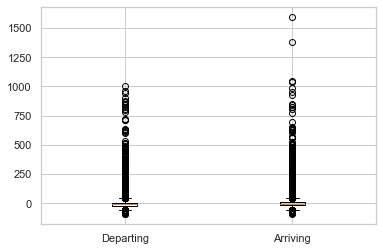

In [21]:
#7. How do the distributions of arrival delays compare in flight leaving Boston vs. flights arriving at Boston.  
# Provide a visual and interpret what you see.
plt.boxplot([bos_flights_train['arrival_delay'][bos_flights_train['origin']=='BOS'],
             bos_flights_train['arrival_delay'][bos_flights_train['dest']=='BOS']])
plt.xticks([1,2],['Departing','Arriving']);

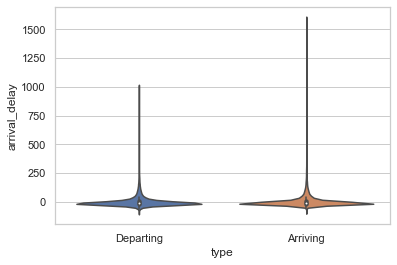

In [22]:
arrive_df = pd.DataFrame(bos_flights_train.loc[bos_flights_train['origin']=='BOS', 'arrival_delay'])
arrive_df['type'] = 'Departing'

depart_df = pd.DataFrame(bos_flights_train.loc[bos_flights_train['dest']=='BOS', 'arrival_delay'])
depart_df['type'] = 'Arriving'

bos_delays_df = pd.concat([arrive_df, depart_df])
sns.violinplot(x='type', y='arrival_delay', data=bos_delays_df);

<span style='color:red'>

**Rubric**

**Q1.6 [15 points total]** 
    
**Points**

- [ -2 ] if they do not use train for each and every one of these questions (except 1.6.5)

- 1.6.1: 
    - [-1] for missing overall proportion 
    - [-1] for not finding December as the most common month

- 1.6.2: 
    - [-1] for not combining departures and arrivals
    - [-1] for not finding Atlanta

- 1.6.3: 
    - [-1] for not using proportions (used counts)
    - [-1] for not finding ADK: Adak Airport (Alaska) or SHR: Sheridan County Airport (Wyoming)

- 1.6.4: 
    - [-1] for not finding the best (HA: Hawaiian Airlines)
    - [-1] for not finding the worst (OH: PSA Airlines)

- 1.6.5: 
    - [-1] for not combining train and test

- 1.6.6: 
    - [-1] for not subsetting just departures
    - [-1] for not calculating arrival delays

- 1.6.7: 
    - [-1] for not providing a reasonable visual (side-by-side boxplots, violin plots, or comparable histograms)
    - [-1] for not mentioning outliers
    - [-1] for not comparing (arrivals are a little later on average).


<div class='exercise'><b>Question 2 [25pts]: Predicting whether a flight was delayed at arrival </b></div>

**2.1** Fit a logistic regression model  to predict whether a flight is delayed or not from the carrier of the flight.  What is the estimated probability for a Sothwest Airlines (`carrier` = 'WN') flight to be delayed?  

**2.2** Calculate and interpret the misclassification rate and AUC for the logit model on the train set.  Explain why this value make sense based on the estimated coefficients from the previous part.

**2.3** Build a well-tuned decision tree model to predict `delayed` from the predictor set: `['month', 'day_of_month', 'day_of_week', 'carrier',  'origin_state','origin','dest',  'dest_state', 'scheduled_depart_time', 'depart_delay','scheduled_arrival_time', 'distance']`.  Use 2-fold cross-validation to to select the best `max_depth` from the set `np.arange(1,21)`.

*Hint: it is useful to use `pd.astype('category')` and `pd.cat.codes` for the categorical predictors.

**2.4** Evaluate the misclassification rate and AUC on both train and test for your well-tuned decision tree in the previous part.  How do these copmare to the logistic regression model?

**2.5** Provide a plot which shows which predictors are most important in building the well-tuned decision tree model.  Interpret this plot.  

**2.6**. If a well-tuned random forest model were built from this set of predictors, would you expect the tuned 'max_features' to be above, below, or nearly equal to the default of $\sqrt{P}$, where $P$ is the number of predictors?  Justify briefly. 


**2.1** Fit a logistic regression model  to predict whether a flight is delayed or not from the carrier of the flight.  What is the estimated probability for a Sothwest Airlines (`carrier` = 'WN') flight to be delayed?  

In [23]:
#2.1
X_train_carrier = pd.get_dummies(train['carrier'], drop_first=True)
X_test_carrier = pd.get_dummies(test['carrier'], drop_first=True)

logit=LogisticRegression(C=10000).fit(X_train_carrier,train['delayed'])
print(logit.intercept_)
logit.coef_

[-1.82749381]


array([[ 0.17902399,  0.39848512,  0.50078125, -0.13508143,  0.31250453,
         0.41603597,  0.57679077, -0.35387145,  0.32787827,  0.1039844 ,
         0.61607865,  0.20486075,  0.17446397, -0.0089062 ,  0.34970723,
         0.13272778]])

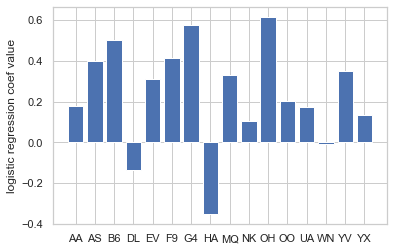

In [24]:
plt.bar(range(len(logit.coef_[0])),logit.coef_[0])
plt.xticks(range(len(X_train_carrier.columns)), labels=X_train_carrier.columns)
plt.ylabel('logistic regression coef value');

In [25]:
x_WN = X_train_carrier[X_train_carrier['WN'] == 1].iloc[0].values.reshape(1,-1)
WN_delay_proba= logit.predict_proba(x_WN)[0][1]
print('WN estimated delay probability:', WN_delay_proba)

WN estimated delay probability: 0.1374776142398017


In [26]:
odds_wn = np.exp(logit.intercept_+logit.coef_[0][X_train_carrier.columns=="WN"])
(odds_wn/(1+odds_wn))[0]

0.13747761423980168

<span style='color:red'>

**Rubric**

**Q2.1 [4 points total]** 
    
**Points**

- [ -1 ] mistakes in handling categorical predictor (i.e., get_dummies, have both an intercept and do not drop the first category)
- [ -1 ] misspecified logistic regression model (-0.5 if they do not set `C` to be large)
- [ -2 ] Incorrect estimate of delay probability for 'WN' carrier


**2.2** Calculate and interpret the misclassification rate and AUC for the logit model on the train set.  Explain why this value make sense based on the estimated coefficients from the previous part.

In [27]:
logit_train_acc = logit.score(X_train_carrier, train['delayed'])
print('train misclassification rate:', 1-logit_train_acc)

logit_train_auc = sk.metrics.roc_auc_score(train['delayed'],logit.predict_proba(X_train_carrier)[:,1])
print('train AUC:', logit_train_auc)

train misclassification rate: 0.15946794502199269
train AUC: 0.5574780354943476


*your answer here*

The misclassification rate is actually the same as the overall proportion of flights that are considered delayed for this very unbalanced response variable.  Since the log-odds are negative for each and every carrier, every predicted classification is a zero, and thus they match (the estimated coefficients are all smaller in magnitude than the very negative intercept).  AUC is very poor which is not surprising since the coefficients are so small in magnitude (and all of our predictors are binaries/dummies) and 

<span style='color:red'>

**Rubric**

**Q2.2 [4 points total]** 
    
**Points**

- [ -1 ] incorrect train misclassification
- [ -1 ] incorrect train AUC
- [ up to -2 ] poor explanation for why these values (especially misclassification rate) make sense (/w reference to coefficients) because the estimated log odds is always negative.  Allow pretty much any reasonable answer for AUC eplanation.

**2.3** Build a well-tuned decision tree model to predict `delayed` from the predictor set: `['month', 'day_of_month', 'day_of_week', 'carrier',  'origin_state','origin','dest',  'dest_state', 'scheduled_depart_time', 'depart_delay','scheduled_arrival_time', 'distance']`.  Use 2-fold cross-validation to to select the best `max_depth` from the set `np.arange(1,21)`.

*Hint: it is useful to use `pd.astype('category')` and `pd.cat.codes` for the categorical predictors.

In [28]:
X_train = train.copy()
X_test = test.copy()
cols = ['month', 'day_of_month', 'day_of_week', 'carrier',
        'origin_state','origin','dest',  'dest_state',
        'scheduled_depart_time', 'depart_delay','scheduled_arrival_time',
        'distance']

def df_proc(original_df, cols=cols):
    df = original_df.copy()
    df = df[cols]
    df.loc[:,'carrier'] = df['carrier'].astype('category')
    # if name == 'train':
    #     # remember code <-> string category mapping
    #     carrier_cats = {code: string for code, string in enumerate(df['carrier'].cat.categories)}
    df.loc[:,'carrier'] = df['carrier'].cat.codes

    df.loc[:,'origin'] = df['origin'].astype('category')
    # if name == 'train':
    #     airport_cats = {code: string for code, string in enumerate(df['origin'].cat.categories)}
    df.loc[:,'origin'] = df['origin'].cat.codes

    df.loc[:,'dest'] = df['dest'].astype('category')
    df.loc[:,'dest'] = df['dest'].cat.codes
    return df

X_train = df_proc(train)
X_test = df_proc(test)

In [29]:
depths = range(1,11)
cv_means = []
cv_stdevs = []
train_scores = []
for d in depths:
    dt = DecisionTreeClassifier(max_depth=d).fit(X_train,train['delayed'])
    train_scores.append(dt.score(X_train, train['delayed']))
    cv_scores = cross_val_score(dt, X_train, train['delayed'], cv=2)
    cv_means.append(cv_scores.mean())
    cv_stdevs.append(cv_scores.std())

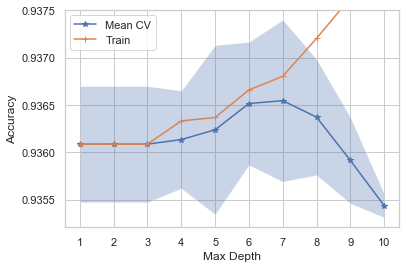

In [30]:
# your code here 
cv_means = np.array(cv_means)
cv_stdevs = np.array(cv_stdevs)


# plot means and shade the 2 SD interval
plt.plot(depths, cv_means, '*-', label="Mean CV")
plt.fill_between(depths, cv_means - 2*cv_stdevs, cv_means + 2*cv_stdevs, alpha=0.3)
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Train")
plt.ylim(ylim)
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths);

In [31]:
dt = DecisionTreeClassifier(max_depth=6).fit(X_train,train['delayed'])

<span style='color:red'>

**Rubric**

**Q2.3 [6 points total]** 
    
**Points**

- [ -2 ] incorrect handling of categorical variables
- [ -1 ] didn't use 2-fold CV
- [ -2 ] didn't tune `max_depth`
- [ -1 ] picked unreasonable `max_depth` or it is unclear why they decided on this value (6 and 7 look good)

**2.4** Evaluate the misclassification rate and AUC on both train and test for your well-tuned decision tree in the previous part.  How do these compare to the logistic regression model?

In [32]:
dt_train_acc = dt.score(X_train, train['delayed'])
print('train misclassification rate:', 1-dt_train_acc)

dt_train_auc = sk.metrics.roc_auc_score(train['delayed'],dt.predict_proba(X_train)[:,1])
print('train AUC:', dt_train_auc)

train misclassification rate: 0.06334119716566333
train AUC: 0.9179979465957102


<span style='color:red'>

    
**Rubric**

**Q2.4 [4 points total]** 
    
**Points**

- [ -1 ] incorrect train misclassification
- [ -1 ] incorrect train AUC
- [ up to -2 ] poor / incorrect / missing comparision to logistic regression model (should reference actual difference in models!)

**2.5** Provide a plot which shows which predictors are most important in building the well-tuned decision tree model.  Interpret this plot. 

In [33]:
dt.feature_importances_

array([0.00000000e+00, 5.55143841e-05, 0.00000000e+00, 3.96677459e-03,
       3.67720854e-05, 1.60985692e-04, 2.81807323e-05, 1.02100259e-04,
       8.15938502e-04, 9.91030714e-01, 0.00000000e+00, 3.80301959e-03])

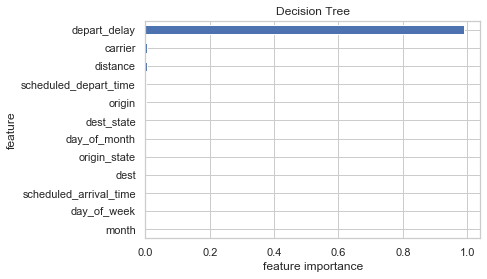

In [34]:
pd.Series(dt.feature_importances_,index=list(X_train)).sort_values().plot(kind="barh");
plt.xlabel('feature importance')
plt.ylabel('feature')
plt.title('Decision Tree');

*your answer here*

`depart_delay` dominates all other features.

<span style='color:red'>
    
**Rubric**

**Q2.5 [3 points total]** 
    
**Points**

- [ up to -2 ] poor / incorrect / missing feature importance plot
- [ -1 ] poor / incorrect / missing interpretation


**2.6**. If a well-tuned random forest model were built from this set of predictors, would you expect the tuned 'max_features' to be above, below, or nearly equal to the default of $\sqrt{P}$, where $P$ is the number of predictors?  Justify briefly.  

*your answer here*

We would expect this number to be tuned to a value **above** the default of $\sqrt{P}$ since there is just one overly dominant feature.  If the number of features randomly slected is too low, then there is a chance that this one feature is never selected for a tree (or only on one branch of the tree), and thus this one base estimator will be very poor, pulling down the accuracy of the entire random forest model.

<span style='color:red'>
    
**Rubric**

**Q2.6 [4 points total]** 
    
**Points**

- [ -2 ] if do not say above/higher than $\sqrt{P}$ 
- [ up to -2 ] poorly justified expectation for ideal max_features based on plot (should be higher than sqrt(P))

<div class='exercise'><b>Question 3 [25pts]: Predicting how delayed a flight will be at arrival </b></div>

**3.1** Fit a linear regression model to predict how much a flight will be delayed on arrival from the scheduled departure time. Plot the fitted line on top of the scatterplot.  What is the estimated delay for a 5am departing flight?  For an 11pm departing flight?

**3.2** Build a well-tuned Lasso model to predict `arrival_delay` from `origin`.  Use 2-fold cross-validation to to select the best `alpha` from the set `10.0**(np.arange(-4,2))`.  For this Lasso model, how many airports are considered to be unimportant?  How is Boston treated?

**3.3** Compare the number of departing flights for origin airports considered to be unimportant to those that are important from the Lasso model.  In what way does this explain why these airports were deemed to be unimportant in the Lasso model?

**3.4** Build a well-tuned random forest model (use 200 base trees and a max_depth of 15) to predict the amount of `arrival_delay` from `['month', 'day_of_month', 'day_of_week', 'carrier',  'origin_state','origin','dest',  'dest_state', 'scheduled_depart_time','depart_delay', 'scheduled_arrival_time', 'distance']`.  Note: feel free to use a subset of your training data set to train this model...just explain your approach.  Evaluate it's performance on the full train and test sets using $R^2$.

**3.5** A friend of yours suggests that airlines can "make up time in the air" if a flight departs late and is a long enough flight.  Investigate this claim visually and interpret what you see.

Hint: Look at the relationship between the Y = predicted amount of arrival delay based on the X = amount of departure delay, for several well-chosen values of `distance`.

## Answers:


**3.1** Fit a linear regression model to predict how much a flight will be delayed on arrival from the scheduled departure time. Plot the fitted line on top of the scatterplot.  What is the estimated delay for a 5am departing flight?  For an 11pm departing flight?

In [35]:
#3.1
ols = LinearRegression().fit(train[['scheduled_depart_time']],train['arrival_delay'])
print('slope:', ols.coef_[0])
print('intercept:', ols.intercept_)

slope: 0.009032477654584944
intercept: -6.138827412992144


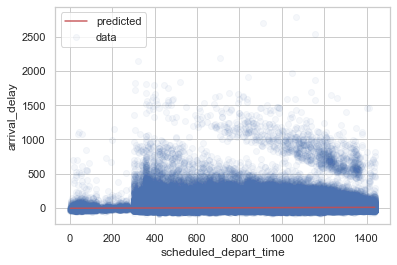

In [36]:
x_dummy = np.linspace(train['scheduled_depart_time'].min(), train['scheduled_depart_time'].max(), 1000)
y_hat = ols.predict(x_dummy.reshape(-1,1))
plt.scatter(train['scheduled_depart_time'], train['arrival_delay'],alpha=0.05, label='data')
plt.plot(x_dummy, y_hat, c='r', alpha=0.9, label='predicted')
plt.ylabel('arrival_delay')
plt.xlabel('scheduled_depart_time')
plt.legend();

In [37]:
delay_5am = ols.predict(np.array([5*60]).reshape(1,-1))[0]
print('predicted delay for 5am departing flight:', delay_5am)
delay_11pm = ols.predict(np.array([23*60]).reshape(1,-1))[0]
print('predicted delay for 11pm departing flight:', delay_11pm)

predicted delay for 5am departing flight: -3.4290841166166603
predicted delay for 11pm departing flight: 6.325991750335079


<span style='color:red'>
    
**Rubric**

**Q3.1 [5 points total]** 
    
**Points**

- [ -1 ] misspecified regression model
- [ up to -2 ] poor / illegible plot (should use dummy Xs!)
- [ -1 each ] incorrect prediction for 5am and /or 11pm departure delay

**3.2** Build a well-tuned Lasso model to predict `arrival_delay` from `origin`.  Use 2-fold cross-validation to to select the best `alpha` from the set `10.0**(np.arange(-4,2))`.  For this Lasso model, how many airports are considered to be unimportant?  How is Boston treated?

In [38]:
X_train_origin = pd.get_dummies(train['origin'], drop_first=True)

alphas = 10.0**(np.arange(-4,2))

lasso = LassoCV(alphas=alphas, cv=2).fit(X_train_origin,train['arrival_delay'])

In [39]:
print("number of 'unimportant' airports:", np.sum(lasso.coef_==0))
print("number of 'important' airports:", np.sum(lasso.coef_!=0))

number of 'unimportant' airports: 149
number of 'important' airports: 204


In [40]:
unimportant = np.array(X_train_origin.columns[lasso.coef_==0])
unimportant

array(['ABR', 'ABY', 'ACT', 'ADK', 'ADQ', 'AEX', 'AGS', 'ALO', 'ATY',
       'AVP', 'BET', 'BFF', 'BFL', 'BFM', 'BJI', 'BKG', 'BMI', 'BPT',
       'BQK', 'BRD', 'BRW', 'BTR', 'CDV', 'CGI', 'CHA', 'CMX', 'CNY',
       'COD', 'COS', 'COU', 'CPR', 'CWA', 'DBQ', 'DDC', 'DHN', 'DRO',
       'DVL', 'EAR', 'EAU', 'EKO', 'ELP', 'EVV', 'EWN', 'FAY', 'FWA',
       'GCC', 'GCK', 'GFK', 'GGG', 'GPT', 'GRB', 'GRI', 'GRK', 'GSO',
       'GTR', 'GUC', 'GUM', 'HDN', 'HGR', 'HIB', 'HOB', 'HTS', 'HVN',
       'HYS', 'IDA', 'IMT', 'JMS', 'JNU', 'KTN', 'LAN', 'LAR', 'LAW',
       'LBB', 'LBE', 'LBF', 'LBL', 'LCH', 'LEX', 'LFT', 'LSE', 'LWB',
       'LWS', 'LYH', 'MBS', 'MEM', 'MHK', 'MKG', 'MLB', 'MLU', 'MMH',
       'MOT', 'MSN', 'MSO', 'MYR', 'OAJ', 'OGD', 'ORF', 'OTH', 'OWB',
       'PAH', 'PGD', 'PGV', 'PHF', 'PIB', 'PIR', 'PRC', 'PSC', 'PSG',
       'PSM', 'PUB', 'PVU', 'PWM', 'RDM', 'RFD', 'RHI', 'RKS', 'ROA',
       'ROC', 'RSW', 'SCC', 'SCE', 'SCK', 'SGU', 'SHD', 'SIT', 'SJT',
       'SLN', 'SMX',

In [41]:
 np.array(X_train_origin.columns[lasso.coef_!=0])

array(['ABI', 'ABQ', 'ACV', 'ACY', 'ALB', 'AMA', 'ANC', 'APN', 'ASE',
       'ATL', 'ATW', 'AUS', 'AVL', 'AZA', 'AZO', 'BDL', 'BGM', 'BGR',
       'BHM', 'BIL', 'BIS', 'BLI', 'BLV', 'BNA', 'BOI', 'BOS', 'BQN',
       'BRO', 'BTM', 'BTV', 'BUF', 'BUR', 'BWI', 'BZN', 'CAE', 'CAK',
       'CDC', 'CHO', 'CHS', 'CID', 'CIU', 'CKB', 'CLE', 'CLL', 'CLT',
       'CMH', 'CMI', 'CRP', 'CRW', 'CSG', 'CVG', 'CYS', 'DAB', 'DAL',
       'DAY', 'DCA', 'DEN', 'DFW', 'DLH', 'DRT', 'DSM', 'DTW', 'ECP',
       'EGE', 'ELM', 'ERI', 'ESC', 'EUG', 'EWR', 'EYW', 'FAI', 'FAR',
       'FAT', 'FCA', 'FLG', 'FLL', 'FNT', 'FSD', 'FSM', 'GEG', 'GJT',
       'GNV', 'GRR', 'GSP', 'GTF', 'HHH', 'HLN', 'HNL', 'HOU', 'HPN',
       'HRL', 'HSV', 'IAD', 'IAG', 'IAH', 'ICT', 'ILM', 'IND', 'INL',
       'ISP', 'ITH', 'ITO', 'JAC', 'JAN', 'JAX', 'JFK', 'JLN', 'KOA',
       'LAS', 'LAX', 'LCK', 'LGA', 'LGB', 'LIH', 'LIT', 'LNK', 'LRD',
       'MAF', 'MCI', 'MCO', 'MDT', 'MDW', 'MEI', 'MFE', 'MFR', 'MGM',
       'MHT', 'MIA',

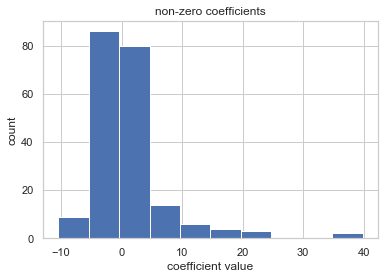

In [42]:
plt.hist(lasso.coef_[lasso.coef_!=0])
plt.title('non-zero coefficients')
plt.ylabel('count')
plt.xlabel('coefficient value');

In [43]:
bos_lasso_coef = lasso.coef_[np.where(X_train_origin.columns == 'BOS')[0][0]]
print('Boston\'s coefficient in Lasso model:', bos_lasso_coef)

Boston's coefficient in Lasso model: -1.099934919162365


*your answer here*

Boston is treated as having a slight negative affect on arrival delay ('negative' as in less delay). Though its magnitute is not extreme based on the histogram of all non-zero coefficients above, it is still deemed important since the coefficient is non-zero.

<span style='color:red'>
    
**Rubric**

**Q3.2 [5 points total]** 
    
**Points**

- [ -1 ] incorrect handling of categorical predictors (drop_first should be True!)
- [ -1 ] doesn't use 2-fold CV
- [ -1 ] somehow manages to choose a strange alpha value
- [ -1 ] incorrected reported # of 'unimportant' airports (305 unimportant if they didn't drop_first :()
- [ -1 ] incorrect description of model's treatment of Boston (Boston is 'unimportant' if they didn't drop_first))

**3.3** Compare the number of departing flights for origin airports considered to be unimportant to those that are important from the Lasso model.  In what way does this explain why these airports were deemed to be unimportant in the Lasso model?

In [44]:
unimportant = np.append(False,(lasso.coef_==0))
important = np.append(False,(lasso.coef_!=0))

airport_departure_counts = np.unique(train['origin'], return_counts=True)

pd.Series(airport_departure_counts[1][unimportant]).describe()

count     149.000000
mean      469.563758
std       863.370355
min         2.000000
25%       111.000000
50%       176.000000
75%       481.000000
max      7533.000000
dtype: float64

In [45]:
pd.Series(airport_departure_counts[1][important]).describe()

count      204.000000
mean      5494.303922
std       9862.159683
min         14.000000
25%        430.000000
50%       1202.000000
75%       4910.750000
max      62410.000000
dtype: float64

*your answer here*

The airports that were deemed important had many more flights than the airports deemed unimportant, on average.  Smaller airports that only had a few flights per day (250 flights in this dataset is roughly 2 flights per day) were often indistinguishable from baseline delay rate, and thus their coefficients were shrunk to zero more commonly. If there is not enough data for an airport, it is likely to be shrunk to zero.

<span style='color:red'>
    

**Rubric**

**Q3.3 [4 points total]** 
    
**Points**

- [ up to -2 ] if their comparison method is not well chosen (just count number of flights total, for example, in each group).  Need some comparision of distribution or summary statistics.
- [ up to -2 ] poor response as to why this explains these airports being labeled unimportant (should reference the fact that there are far fewer flights for these unimportant airports)

**3.4** Build a well-tuned random forest model (use 200 base trees and a max_depth of 15) to predict the amount of `arrival_delay` from `['month', 'day_of_month', 'day_of_week', 'carrier',  'origin_state','origin','dest',  'dest_state', 'scheduled_depart_time','depart_delay', 'scheduled_arrival_time', 'distance']`.  Note: feel free to use a subset of your training data set to train this model...just explain your approach.  Evaluate it's performance on the full train and test sets using $R^2$.


In [46]:
i_subset, _ = train_test_split(range(train.shape[0]), train_size=0.1,random_state=109,shuffle=True)
X_train_subset = X_train.iloc[i_subset]
y_train_subset = train['arrival_delay'].iloc[i_subset]

In [47]:
max_features = [2,4,6,8,10]
cv_means = []
cv_stdevs = []
train_scores = []
for mf in max_features:
    rf = RandomForestRegressor(200,max_depth=15,max_features=mf).fit(X_train_subset, y_train_subset)
    train_scores.append(rf.score(X_train_subset, y_train_subset))
    cv_scores = cross_val_score(rf, X_train_subset, y_train_subset, cv=2)
    cv_means.append(cv_scores.mean())
    cv_stdevs.append(cv_scores.std())

In [48]:
train_scores

[0.910638872172057,
 0.9424048903272794,
 0.9469184656568249,
 0.9477759061990765,
 0.9479404297536229]

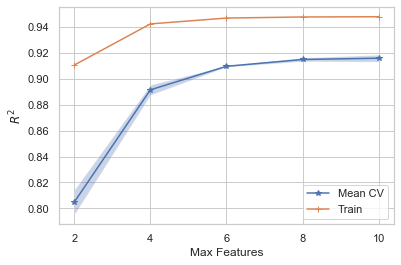

In [49]:
# your code here 
cv_means = np.array(cv_means)
cv_stdevs = np.array(cv_stdevs)

# plot means and shade the 2 SD interval
plt.plot(max_features, cv_means, '*-', label="Mean CV")
plt.fill_between(max_features, cv_means - 2*cv_stdevs, cv_means + 2*cv_stdevs, alpha=0.3)
# ylim = plt.ylim()
plt.plot(max_features, train_scores, '-+', label="Train")
# plt.ylim(ylim)
plt.legend()
plt.ylabel(r"$R^2$")
plt.xlabel("Max Features")
plt.xticks(max_features);

In [50]:
rf = RandomForestRegressor(200,max_depth=15,max_features=10).fit(X_train_subset, y_train_subset)

In [51]:
rf.score(X_train, train['arrival_delay'])

0.9249193734486681

In [52]:
rf.score(X_test, test['arrival_delay'])

0.920502370184661

<span style='color:red'>
    
**Rubric**

**Q3.4 [6 points total]** 

**Note**
Some students may be evaluating in batches...that is 100% fine
    
**Points**

- [ -2 ] does not tune max features
- [ -1 ] doesn't use 200 trees /w depth 15
- [ up to -2 ] if do not justify their approach to subsampling or they sample too few observations (1% or fewer).
- [ -1 each ] missing train/test R^2 scores (these should be >= 0.89)

**3.5** A friend of yours suggests that airlines can "make up time in the air" if a flight departs late and is a long enough flight.  Investigate this claim visually and interpret what you see.

Hint: Look at the relationship between the Y = predicted amount of arrival delay based on the X = amount of departure delay, for several well-chosen values of `distance`.

Short b0 =  -6.083 Short b1 =  1.011903
Med b0 =  -7.322 Medium b1 =  1.006201
Long b0 =  -10.216 Long b1 =  1.000603


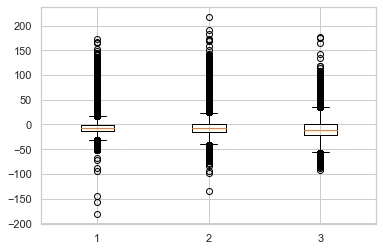

In [53]:
# your code here

short_flights = train.loc[train['distance']<=500]
med_flights = train.loc[(train['distance']>500) &(train['distance']<=2000)]
long_flights = train.loc[train['distance']>2000]

plt.boxplot([short_flights['arrival_delay']-short_flights['depart_delay'], 
             med_flights['arrival_delay']-med_flights['depart_delay'],
             long_flights['arrival_delay']-long_flights['depart_delay']]);

short_ols = LinearRegression( fit_intercept=True).fit(short_flights[['depart_delay']], short_flights['arrival_delay'])
print("Short b0 = ",np.round(short_ols.intercept_,3),"Short b1 = ",np.round(short_ols.coef_[0],6))

med_ols = LinearRegression( fit_intercept=True).fit(med_flights[['depart_delay']], med_flights['arrival_delay'])
print("Med b0 = ",np.round(med_ols.intercept_,3),"Medium b1 = ",np.round(med_ols.coef_[0],6))

long_ols = LinearRegression( fit_intercept=True).fit(long_flights[['depart_delay']], long_flights['arrival_delay'])
print("Long b0 = ",np.round(long_ols.intercept_,3),"Long b1 = ",np.round(long_ols.coef_[0],6))


*your answer here*

There is some evidence from the linear regression models above that airlines can make up time in the air, but every so slightly.  A longer flight will be able to make up a delayed departure based on these models: for a flight that takes off an hour late, the estimated arrival delay would be $-6.083+1.0119\times60 = 54.6$ minutes for a short flight (less than 500 miles), $-7.322+1.0062*\times60=53.1$ minutes for a medium length flight (500-2000 miles), and $-10.216+1.0006\times 60 = 49.8$ minutes for a long flight (greater than 2000 miles).



<span style='color:red'>
    
**Rubric**

**Q3.5 [5 points total]** 
    
**Points**

- [ up to -2 ] does not choose a good display or approach: should explore various relationships for each distance investigated (range of distances)...using predictions from previous model is fine.
- [ -1 ] illegible / confusing plot
- [ up to -2 ] poor or lacking interpretation

<div class='exercise'><b>Question 4 [20pts]: Predicting delays out of Boston </b></div>

For this question, use the `bos_flights_train` and `bos_flights_test` data sets you created in question 1.

**4.1** Build a boosted tree-based model to predict whether or not a Boston flight will be delayed from `['month', 'day_of_month', 'day_of_week', 'carrier',  'origin_state','origin','dest',  'dest_state', 'scheduled_depart_time',,'depart_delay', 'scheduled_arrival_time', 'distance']`. Justify your choices for the 3 parameters that could be tuned for this model (a visual or set of visuals can help for this).  Evaluate the accuracy of this model on the test set.

**4.2** Build a fully-connected neural network (NN) model to predict the amount of `arrival_delay` from `['month', 'day_of_month', 'day_of_week', 'carrier',  'origin_state','origin','dest',  'dest_state', 'scheduled_depart_time', ,'depart_delay','scheduled_arrival_time', 'distance']` in Boston flights.  Briefly justify your choice for the network architecture. Evaluate the accuracy of this model on the test set.

**4.3** You have a scheduled flight on United Arilines (UA) from Boston (BOS) to San Francisco (SFO) that is scheduled to depart at 2pm on Wednesday, November 26 (the day before Thanksgiving) and arrive at 5:15pm.  Use your models in the previous two parts to determine the (i) probability that the flight will be delayed on arrival and (ii) predicted amount of arrival delay given it takes off anywhere from 5 minutes early to 2 hours late.

**4.4** The data set `bos_weather.csv` includes daily weather from this same time period .  Use this dataset and the boston flight data to investigate the effect of weather (precipitation, temperature, etc.) on flight delays at Logan Airport.  Would this extra data source improve the predictions from the models in 4.1 and 4.2?  Explain.

## Answers

**4.1** Build a boosted tree-based model to predict whether or not a Boston flight will be delayed from `['month', 'day_of_month', 'day_of_week', 'carrier',  'origin_state','origin','dest',  'dest_state', 'scheduled_depart_time',,'depart_delay', 'scheduled_arrival_time', 'distance']`. Justify your choices for the 3 parameters that could be tuned for this model (a visual or set of visuals can help for this).  Evaluate the accuracy of this model on the test set.

In [54]:
for df in [bos_flights_train, bos_flights_test]:
    for col in df.columns:
        if df[col].dtype == object:
            df.loc[:, col] = df[col].astype('category').cat.codes

/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


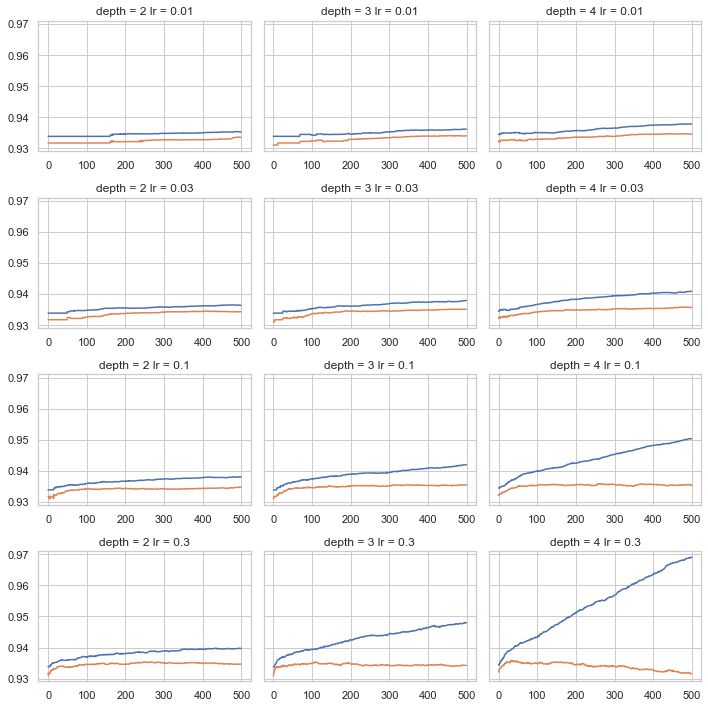

In [55]:
cols = ['month', 'day_of_month', 'day_of_week', 'carrier',
        'origin_state','origin','dest',  
        'dest_state', 'scheduled_depart_time',
        'depart_delay', 'scheduled_arrival_time', 'distance']
train_scores_dict = {}
test_scores_dict = {}
depths = [2,3,4]
lrs = [0.01, 0.03, 0.1, 0.3]
fig, axs = plt.subplots(len(lrs), len(depths), sharey=True, figsize=(10,10))
for i, lr in enumerate(lrs):
    for j, d in enumerate(depths):
        ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d), n_estimators=500, learning_rate=lr)
        ada.fit(bos_flights_train[cols],bos_flights_train['delayed']) 
        train_scores = list(ada.staged_score(bos_flights_train[cols], bos_flights_train['delayed']))
        test_scores = list(ada.staged_score(bos_flights_test[cols], bos_flights_test['delayed']))
        train_scores_dict[(d,lr)] = train_scores
        test_scores_dict[(d,lr)] = test_scores
        axs[i,j].plot(train_scores)
        axs[i,j].plot(test_scores)
        axs[i,j].set_title(f'depth = {d} lr = {lr}')
plt.tight_layout();

In [57]:
for k, v in test_scores_dict.items():
    print(k, max(v))

(2, 0.01) 0.9336112493777999
(3, 0.01) 0.9340882694541232
(4, 0.01) 0.9347104695536751
(2, 0.03) 0.9345238095238095
(3, 0.03) 0.9351460096233616
(4, 0.03) 0.9358096897295504
(2, 0.1) 0.9347519495603119
(3, 0.1) 0.9355193296830927
(4, 0.1) 0.9358511697361872
(2, 0.3) 0.9353948896631823
(3, 0.3) 0.9353534096565456
(4, 0.3) 0.9358719097395055


In [58]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=30, learning_rate=0.3)
ada.fit(bos_flights_train[cols],bos_flights_train['delayed']) 

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=4,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [59]:
test_acc = ada.score(bos_flights_test[cols], bos_flights_test['delayed'])
print('test accuracy:', test_acc)

test accuracy: 0.9351667496266799


*your answer here*


<span style='color:red'>
    
**Rubric**

**Q4.1 [6 points total]**

**Points**
- [ -1 ] for an incorrectly specified adaboost model (regression, for example)
- [ -1 ] if they tuned using the test set
- [ -1 ] if they did not report accuracy on the test set
- [ up to -3 ] if they did not justify their choices for the 3 parameters well or did zero tuning (selecting and justfying a specified depth and learning rate, and tuning just the # estimators is good enough here).

**4.2** Build a fully-connected neural network (NN) model to predict the amount of `arrival_delay` from `['month', 'day_of_month', 'day_of_week', 'carrier',  'origin_state','origin','dest',  'dest_state', 'scheduled_depart_time', ,'depart_delay','scheduled_arrival_time', 'distance']` in Boston flights.  Briefly justify your choice for the network architecture. Evaluate the accuracy of this model on the test set.

In [61]:
######
# your code here
######
# your code here
nn_cols = ['month', 'day_of_month',
           'day_of_week', 'carrier', 'origin_state','origin','dest',
           'dest_state', 'scheduled_depart_time', 'depart_delay',
           'scheduled_arrival_time', 'distance']

# Build the model 
model_NN = tf.keras.Sequential([
    tf.keras.layers.Dense(100, input_shape = (len(nn_cols),), activation = 'relu'),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(50, activation = 'relu'),
    tf.keras.layers.Dense(50, activation = 'relu'),    
    tf.keras.layers.Dense(25, activation = 'relu'),
    tf.keras.layers.Dense(25, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'linear')
])

# Configure the model for training
model_NN.compile(loss = 'mse', optimizer = 'adam')

# Train the model on the X_train_nn data for 100 epochs
history = model_NN.fit(bos_flights_train[nn_cols], bos_flights_train['arrival_delay'], epochs=100, batch_size=256, validation_split = 0.2, verbose=1)





Epoch 1/100
153/153 [==============================] - 0s 2ms/step - loss: 1076.4611 - val_loss: 307.6234
Epoch 2/100
153/153 [==============================] - 0s 2ms/step - loss: 310.5328 - val_loss: 290.3417
Epoch 3/100
153/153 [==============================] - 0s 2ms/step - loss: 290.9115 - val_loss: 266.8076
Epoch 4/100
153/153 [==============================] - 0s 2ms/step - loss: 281.1368 - val_loss: 274.2914
Epoch 5/100
153/153 [==============================] - 0s 2ms/step - loss: 284.9301 - val_loss: 271.2798
Epoch 6/100
153/153 [==============================] - 0s 2ms/step - loss: 279.9231 - val_loss: 265.1277
Epoch 7/100
153/153 [==============================] - 0s 2ms/step - loss: 275.1054 - val_loss: 266.5147
Epoch 8/100
153/153 [==============================] - 0s 2ms/step - loss: 273.5721 - val_loss: 288.4095
Epoch 9/100
153/153 [==============================] - 0s 2ms/step - loss: 275.0587 - val_loss: 258.2260
Epoch 10/100
153/153 [==============================] 

In [96]:
bos_flights_train[nn_cols].head()

,month,day_of_month,day_of_week,carrier,origin_state,origin,dest,dest_state,scheduled_depart_time,depart_delay,scheduled_arrival_time,distance
397537,12,16,1,WN,25,BOS,BWI,24,1085,-4.0,1195,369
336217,1,27,1,B6,25,BOS,MSY,22,960,-1.0,1139,1368
165855,12,2,1,AA,25,BOS,MIA,12,339,135.0,557,1258
280154,1,19,7,YX,39,CMH,BOS,25,480,-6.0,611,640
191819,12,1,7,DL,6,LAX,BOS,25,495,-2.0,1012,2611


In [63]:
yhat_train_nn = model_NN.predict(bos_flights_train[nn_cols])
yhat_test_nn = model_NN.predict(bos_flights_test[nn_cols])

ANN_train_score = sk.metrics.r2_score(bos_flights_train['arrival_delay'], yhat_train_nn)
ANN_test_score = sk.metrics.r2_score(bos_flights_test['arrival_delay'], yhat_test_nn)

# Print the scores
print("R-squared scores of the neural network model:")
print("\tTrain R-squared score= {}".format(ANN_train_score))
print("\tTest R-squared score = {}".format(ANN_test_score))

R-squared scores of the neural network model:
	Train R-squared score= 0.9101151077462727
	Test R-squared score = 0.9107314261052097


<ins>**Solution:**</ins>

There are 3 necessities to building this network:
1. the output layer must have a linear activation
2. the loss function should be MSE
3. the evaluation of accuracy should be $R^2$, which is easy to calculate based on MSE.

Optional values: the above Keras model uses 6 hidden layers and relu activations in each layer.  Relu was chosen because it is a very discrete activation, and allows for very flexible signal approximations.  

<span style='color:red'>

**Rubric**

**Q4.2 [6 points total]**

**Points**
- [ -1 ] if they did not use MSE (or justify using MAE) as loss function.
- [ -1 ] if they did not use linear activation in output layer.
- [ -1 ] if they did not evaluate accuracy with $R^2$.
- [ -1 ] if their model is way too complex or way too simple
- [ up to -2 ] if they did not explain their model architecture well.

**4.3** You have a scheduled flight on United Arilines (UA) from Boston (BOS) to San Francisco (SFO) that is scheduled to depart at 2pm on Wednesday, November 26 (the day before Thanksgiving) and arrive at 5:15pm.  Use your models in the previous two parts to determine the (i) probability that the flight will be delayed on arrival and (ii) predicted amount of arrival delay given it takes off anywhere from 5 minutes early to 2 hours late.

Distance from BOS to SFO: 2704
The four carriers to choose from: (array(['AS', 'B6', 'DL', 'UA'], dtype=object), array([ 88, 294,  49, 334]))
Dimension of predictor X: (126, 12)


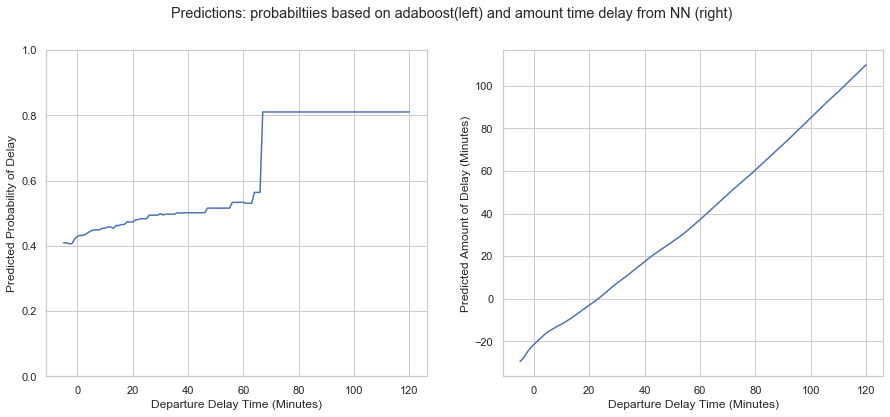

In [85]:
###### # your code here
######

carriers = np.unique(train[['carrier']][(train['origin']=="BOS")&(train['dest']=="SFO")],return_counts=True)
dist = np.unique(train[['distance']][(train['origin']=="BOS")&(train['dest']=="SFO")],return_counts=True)[0][0]
print("Distance from BOS to SFO:", dist)
print("The four carriers to choose from:", carriers)


delay_times = np.arange(-5,121)
x = pd.Series([11,26,3,11,25,3,55,6,840,0,1035,dist])
x.index = ['month', 'day_of_month','day_of_week', 'carrier', 'origin_state','origin','dest','dest_state', 'scheduled_depart_time', 'depart_delay','scheduled_arrival_time', 'distance']


X_BOS_SFO = pd.DataFrame([np.transpose(x)]*delay_times.size)
X_BOS_SFO['depart_delay'] = delay_times
print("Dimension of predictor X:", X_BOS_SFO.shape)
X_BOS_SFO.head()


# predicted probability from the adaBoost model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Predictions: probabiltiies based on adaboost(left) and amount time delay from NN (right)')


yhat_BOS_SFO_ada =ada.predict_proba(np.asarray(X_BOS_SFO))[:,1]
ax1.plot(delay_times,yhat_BOS_SFO_ada);
ax1.set_ylim((0,1))
ax1.set(xlabel='Departure Delay Time (Minutes)', ylabel='Predicted Probability of Delay')
# predicted delay time from the NN model:

yhat_BOS_SFO_NN = model_NN.predict(np.asarray(X_BOS_SFO))
ax2.plot(delay_times,yhat_BOS_SFO_NN)
ax2.set(xlabel='Departure Delay Time (Minutes)', ylabel='Predicted Amount of Delay (Minutes)')

plt.show();

<span style='color:red'>

**Rubric**

**Q4.3 [4 points total]**

**Points**
- [ -1 ] if they did not predict at each value of -5, -4, ..., 119, 120.
- [ -1 ] if they did not use the boost model (4.1) for probabilities or NN model for amount of delay (4.2)
- [ -1 ] if they calculated predicted probabiilties incorrectly (did pure classifications, for example).
- [ -1 ] if they calculated predicted times incorrectly.

**4.4** The data set `bos_weather.csv` includes daily weather from this same time period .  Use this dataset and the boston flight data to investigate the effect of weather (precipitation, temperature, etc.) on flight delays at Logan Airport.  Would this extra data source improve the predictions from the models in 4.1 and 4.2?  Explain.

In [90]:
# your code here

bos_weather = pd.read_csv('data/bosweather.csv')
print(bos_weather.shape)
bos_weather.head()

(121, 8)


,year,month,day,meantemp,meanhumid,meanwind,meanpress,precip
0,2019,11,1,57.2,49.3,21.6,29.8,0.07
1,2019,11,2,45.7,52.0,6.9,30.1,0.00
2,2019,11,3,48.9,45.4,10.0,30.0,0.00
3,2019,11,4,48.2,46.7,8.6,30.3,0.00
4,2019,11,5,54.7,80.7,7.2,30.1,0.00


In [92]:
bos_flights_train.head()

,year,month,day_of_month,day_of_week,carrier,tail_number,origin,origin_state,dest,dest_state,scheduled_depart_time,actual_depart_time,depart_delay,taxi_out,taxi_in,scheduled_arrival_time,actual_arrival_time,arrival_delay,cancelled,diverted,elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,delayed
397537,2019,12,16,1,12,2818,3,25,6,24,1085,1081.0,-4.0,22.0,4.0,1195,1178.0,-17.0,0,0,97.0,71.0,369,0,0,0,0,0,0
336217,2020,1,27,1,3,1660,3,25,38,22,960,959.0,-1.0,23.0,5.0,1139,1120.0,-19.0,0,0,221.0,193.0,1368,0,0,0,0,0,0
165855,2019,12,2,1,1,297,3,25,35,12,339,474.0,135.0,22.0,8.0,557,678.0,121.0,0,0,204.0,174.0,1258,1,0,0,0,0,1
280154,2020,1,19,7,14,339,10,39,3,25,480,474.0,-6.0,22.0,9.0,611,586.0,-25.0,0,0,112.0,81.0,640,0,0,0,0,0,0
191819,2019,12,1,7,4,2017,29,6,3,25,495,493.0,-2.0,15.0,15.0,1012,982.0,-30.0,0,0,309.0,279.0,2611,0,0,0,0,0,0


In [97]:
delay_by_day = bos_flights_train.groupby(['month','day_of_month']).mean()['delayed']
delay_by_day.head()

month  day_of_month
1      1               0.096096
       2               0.103448
       3               0.082687
       4               0.243243
       5               0.154040
Name: delayed, dtype: float64

In [101]:
bos_weather['day_of_month']=bos_weather['day']
merged=pd.merge(bos_weather,delay_by_day,on=['month','day_of_month'])




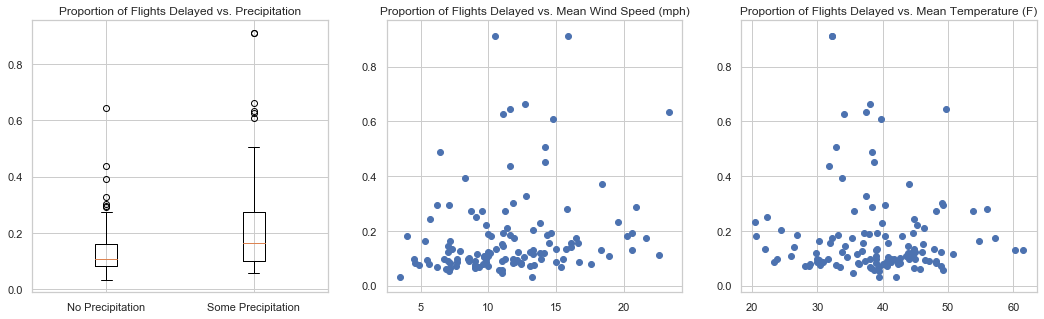

In [107]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))

ax1.boxplot([merged['delayed'][merged['precip']==0],merged['delayed'][merged['precip']>0]]);
ax1.set_xticklabels(['No Precipitation','Some Precipitation']);
ax1.set_title('Proportion of Flights Delayed vs. Precipitation')

ax2.scatter(merged['meanwind'],merged['delayed']);
ax2.set_title('Proportion of Flights Delayed vs. Mean Wind Speed (mph)')


ax3.scatter(merged['meantemp'],merged['delayed']);
ax3.set_title('Proportion of Flights Delayed vs. Mean Temperature (F)')

plt.show()

*your answer here*

Note: in order to merge, it is simplest to do a group_by for date on the Boston flights dataset, and look at the proportion of flights that are delayed for each date.  Based on the above visuals, it does look like the weather, mainly the precipitation amount, is quite associated with delay amount.  This does not necessarily mean that using weather will improve the modeling done in 4.1 and 4.2: it is a question of whether the weather provides any additional predictivce ability beyond the predictor set already used (mainly, the dominant predictor of `depart_delay`).

<span style='color:red'>
    
**Rubric**

**Q4.4 [4 points total]**

**Points**
- [ -1 ] if they did not "merge" data properly (either look at collapsed flights to days, or apply weather data to all the flights on that day)
- [ -1 ] for well chosen visuals/summaries
- [ -1 ] for interpreting their visuals/summaries
- [ -1 ] if poor justification for whether this could improve the models.